# MASS database inspection

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import sys

import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import pprint

detector_path = '..'
sys.path.append(detector_path)

from sleep.mass import MASS
from sleep.mass import KEY_EEG, KEY_PAGES, KEY_ID, KEY_MARKS
from sleep.data_ops import seq2inter, inter2seq, seq2inter_with_pages
from evaluation.eval_ops import by_sample_confusion, by_sample_iou, by_event_confusion, matching

%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
dataset = MASS(load_checkpoint=True)

Dataset mass with 14 patients.
Train size: 10. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 19]
Test subjects: 
 [2, 6, 12, 13]
Loading from checkpoint
Loaded


## Checking general numbers

In [6]:
print('Sample frequency:', dataset.fs)
print('Page duration and size:', dataset.page_duration, dataset.page_size)
print('Registers ids:', dataset.all_ids)
print('Number of loaded registers:', len(dataset.data))
print('')
print('Train set IDs:', dataset.train_ids)
print('Test set IDs:', dataset.test_ids)

Sample frequency: 200
Page duration and size: 20 4000
Registers ids: [1, 2, 3, 5, 6, 7, 9, 10, 11, 12, 13, 14, 17, 19]
Number of loaded registers: 14

Train set IDs: [1, 3, 5, 7, 9, 10, 11, 14, 17, 19]
Test set IDs: [2, 6, 12, 13]


## Check one subject

In [40]:
def plot_subject_global(signal, fs, pages, page_size, marks_1, marks_2):
    time_axis = np.arange(signal.size) / fs
    max_time = time_axis[-1]
    
    n_pages = np.ceil(signal.size / page_size).astype(int)
    n2_stages = np.zeros(n_pages, dtype=np.uint8)
    for page in pages:
        n2_stages[page] = 1
    
    marks_1_in_page = np.zeros(n_pages, dtype=np.int32)
    marks_2_in_page = np.zeros(n_pages, dtype=np.int32)
    marks_1_n2_without_marks = 0
    marks_2_n2_without_marks = 0
    marks_both_n2_without_marks = 0
    for page in pages:
        start_sample = page * page_size
        end_sample = (page+1) * page_size
        marks_1_presence = np.sum(marks_1[start_sample:end_sample])
        marks_2_presence = np.sum(marks_2[start_sample:end_sample])
        if marks_1_presence == 0:
            marks_1_n2_without_marks += 1
        if marks_2_presence == 0:
            marks_2_n2_without_marks += 1
        if marks_1_presence == 0 and marks_2_presence == 0:
            marks_both_n2_without_marks += 1
        marks_1_in_page[page] = marks_1_presence
        marks_2_in_page[page] = marks_2_presence
    
    print('Number of N2 pages without E1 marks: %d' % marks_1_n2_without_marks)
    print('Number of N2 pages without E2 marks: %d' % marks_2_n2_without_marks)
    print('Number of N2 pages without any marks: %d' % marks_both_n2_without_marks)
    
    fig, ax = plt.subplots(4, 1, figsize=(15, 7))
    
    ax[0].set_title('Normalized EEG Signal')
    ax[0].plot(time_axis, signal)
    ax[0].set_xlabel('Time [s]')
    ax[0].set_xlim([0, max_time])

    ax[1].set_title('N2 stages (white is active)')
    ax[1].imshow(n2_stages[np.newaxis, :], interpolation=None, aspect='auto', cmap='gray', extent=[0, max_time, 0, 1])
    ax[1].axis('off')
    
    ax[2].set_title('E1 marks presence (white is active)')
    ax[2].imshow(marks_1_in_page[np.newaxis, :], interpolation=None, aspect='auto', extent=[0, max_time, 0, 1], cmap='gray')
    ax[2].axis('off')
    
    ax[3].set_title('E2 marks presence (white is active)')
    ax[3].imshow(marks_2_in_page[np.newaxis, :], interpolation=None, aspect='auto', extent=[0, max_time, 0, 1], cmap='gray')
    ax[3].axis('off')
    
    plt.tight_layout()
    plt.show()

### Complete register visualization

In [41]:
# Registers ids: [1, 2, 3, 5, 6, 7, 9, 10, 11, 12, 13, 14, 17, 19]
subject_id = 1

In [42]:
ind_idx = dataset.all_ids.index(subject_id)
ind_dict = dataset.data[ind_idx]
subject_id = ind_dict[KEY_ID]
signal = ind_dict[KEY_EEG]
pages = ind_dict[KEY_PAGES]
marks_1 = ind_dict['%s_1' % KEY_MARKS]
marks_2 = ind_dict['%s_2' % KEY_MARKS]

print('Loaded subject ID %s' % subject_id)
print('Signal size %d. Number of pages %d' % (signal.shape[0], pages.shape[0]))

Loaded subject ID 1
Signal size 5791600. Number of pages 745


Number of N2 pages without E1 marks: 201
Number of N2 pages without E2 marks: 73
Number of N2 pages without any marks: 71


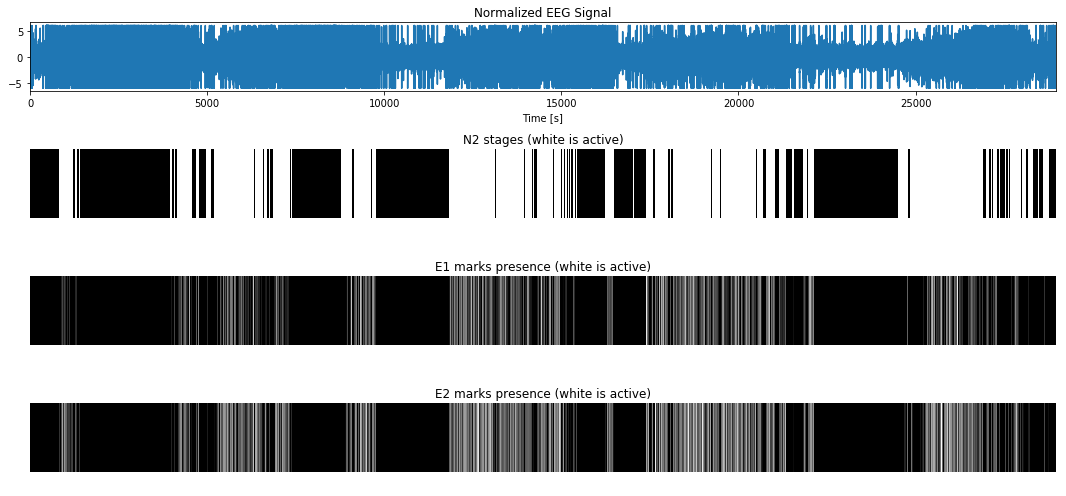

In [43]:
plot_subject_global(signal, dataset.fs, pages, dataset.page_size, marks_1, marks_2)

## Marks statistics from saved data

In [17]:
marks_1_stamps = seq2inter(marks_1)
marks_2_stamps = seq2inter(marks_2)
print('Number of marks from E1: %d' % marks_1_stamps.shape[0])
print('Number of marks from E2: %d' % marks_2_stamps.shape[0])

Number of marks from E1: 1044
Number of marks from E2: 2374


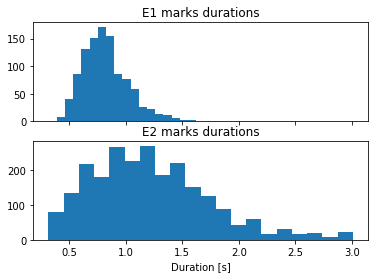

In [18]:
durations_1 = np.diff(marks_1_stamps)[:, 0] / dataset.fs
durations_2 = np.diff(marks_2_stamps)[:, 0] / dataset.fs

fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].hist(durations_1, bins=20)
ax[0].set_title('E1 marks durations')
ax[1].hist(durations_2, bins=20)
ax[1].set_title('E2 marks durations')
ax[1].set_xlabel('Duration [s]')
plt.show()

In [19]:
# Compute statistics comparing E1 and E2

# By sample
print('By Sample Stats between E1 and E2:')
bs_metrics = by_sample_confusion(marks_1, marks_2, input_is_binary=True)
bs_iou = by_sample_iou(marks_1, marks_2, input_is_binary=True)
print('BS IoU: %1.4f' % bs_iou)
pprint.pprint(bs_metrics)

# By event
print('\nBy Event stats between E1 and E2:')
print('Number of marks from E1: %d' % marks_1_stamps.shape[0])
print('Number of marks from E2: %d' % marks_2_stamps.shape[0])
iou_array, idx_e2_marks = matching(marks_1_stamps, marks_2_stamps)
nonzero_iou_array = iou_array[iou_array > 0]
print('Number of nonzero iou marks:', nonzero_iou_array.shape[0])
be_metrics = by_event_confusion(marks_1_stamps, marks_2_stamps, iou_array=iou_array)
pprint.pprint(be_metrics)

By Sample Stats between E1 and E2:
BS IoU: 0.2905
{'f1_score': 0.45023793265897033,
 'fn': 2591,
 'fp': 412851,
 'precision': 0.2918119004816731,
 'recall': 0.984997799754499,
 'tp': 170117}

By Event stats between E1 and E2:
Number of marks from E1: 1044
Number of marks from E2: 2374
Number of nonzero iou marks: 1038
{'f1_score': 0.5868929198361615,
 'mean_all_iou': 0.6000775592575726,
 'mean_nonzero_iou': 0.603546215669466,
 'n_detections': 2374,
 'n_events': 1044,
 'precision': 0.42249368155012634,
 'recall': 0.960727969348659,
 'tp': 1003}


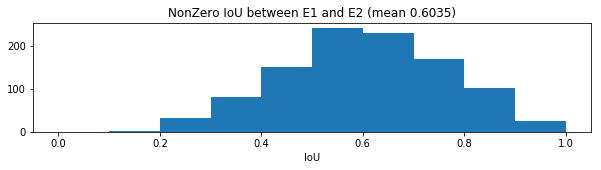

In [20]:
fig = plt.figure(figsize=(10,2))
plt.hist(nonzero_iou_array, bins=[i*0.1 for i in range(11)])
plt.xlabel('IoU')
plt.title('NonZero IoU between E1 and E2 (mean %1.4f)' % be_metrics['mean_nonzero_iou'])
plt.show()

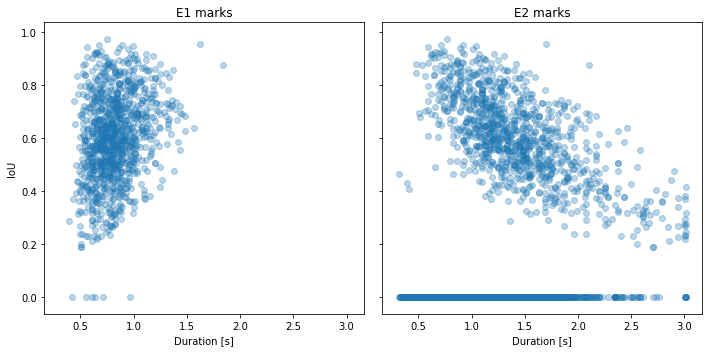

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

ax[0].set_title('E1 marks')
ax[0].scatter(durations_1, iou_array, alpha=0.3)
ax[0].set_xlabel('Duration [s]')
ax[0].set_ylabel('IoU')

iou_array_e2 = np.zeros(durations_2.shape)
for i, idx in enumerate(idx_e2_marks):
    if idx != -1:
        iou_array_e2[idx] = iou_array[i]

ax[1].set_title('E2 marks')
ax[1].scatter(durations_2, iou_array_e2, alpha=0.3)
ax[1].set_xlabel('Duration [s]')

plt.tight_layout()
plt.show()

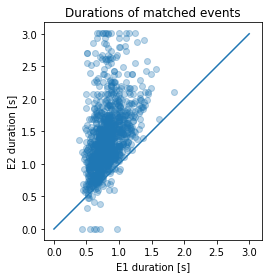

In [22]:
durations_2_matched = np.zeros(durations_1.shape)
for i, idx in enumerate(idx_e2_marks):
    if idx != -1:
        durations_2_matched[i] = durations_2[idx]
        
plt.title('Durations of matched events')
plt.scatter(durations_1, durations_2_matched, alpha=0.3)
plt.plot([0, 3], [0, 3])
plt.xlabel('E1 duration [s]')
plt.ylabel('E2 duration [s]')
plt.xlim([0, 3])
plt.ylim([0, 3])
plt.axis('square')
plt.show()

## Page visualization

In [23]:
n2_signal, n2_marks_1 = dataset.get_subject_data(subject_id, which_expert=1, verbose=True)
_, n2_marks_2 = dataset.get_subject_data(subject_id, which_expert=2, verbose=True)
pages = dataset.get_subject_pages(subject_id)

Getting ID 1, 745 N2 pages, Expert 1
Getting ID 1, 745 N2 pages, Expert 2


In [24]:
print('Number of n2 pages:', n2_signal.shape)
tmp = np.sum(n2_marks_1, axis=1)
tmp = sum((tmp==0).astype(int))
print('Number of pages without E1 marks:', tmp)
tmp = np.sum(n2_marks_2, axis=1)
tmp = sum((tmp==0).astype(int))
print('Number of pages without E2 marks:', tmp)

Number of n2 pages: (745, 4000)
Number of pages without E1 marks: 201
Number of pages without E2 marks: 73


In [25]:
n2_marks_1_stamps = seq2inter_with_pages(n2_marks_1, pages)
n2_marks_2_stamps = seq2inter_with_pages(n2_marks_2, pages)
print('Number of E1 marks:', n2_marks_1_stamps.shape)
print('Number of E2 marks:', n2_marks_2_stamps.shape)

Number of E1 marks: (1041, 2)
Number of E2 marks: (2367, 2)


In [34]:
def plot_page(page, signal, e1_marks, e2_marks, n2_pages, fs):
    fig = plt.figure(figsize=(20, 6)) 
    gs = gridspec.GridSpec(3, 1, height_ratios=[4, 1, 1]) 
    
    page = page - 1
    
    segment_signal = signal[page, :]
    segment_e1_marks = e1_marks[page, :]
    segment_e2_marks = e2_marks[page, :]
    time_axis = np.arange(signal.shape[1])/fs
    
    # Signal
    ax0 = fig.add_subplot(gs[0])
    ax0.plot(time_axis, segment_signal)
    ax0.set_yticks([])
    ax0.set_xlim([0, 20])
    ax0.set_ylim([-6, 6])
    ax0.set_title('EEG Signal, C3-CLE (intervals of 0.5s are shown), original page %d' % n2_pages[page])
    ax0.set_xticks([0, 5, 10, 15, 20])
    ax0.set_xticks(np.arange(0, 20, 0.5), minor=True)
    ax0.grid(b=True, axis='x', which='minor')
    
    # Expert mark
    ax2 = fig.add_subplot(gs[1])
    ax2.imshow(segment_e1_marks[np.newaxis, :], interpolation=None, aspect='auto', cmap='gray')
    ax2.axis('off')
    ax2.set_title('Expert 1 (white is active)')
    
    ax3 = fig.add_subplot(gs[2])
    ax3.imshow(segment_e2_marks[np.newaxis, :], interpolation=None, aspect='auto', cmap='gray')
    ax3.axis('off')
    ax3.set_title('Expert 2 (White is active)')
    
    plt.tight_layout()
    plt.show()

In [35]:
widgets.interact(
    lambda page: plot_page(page, n2_signal, n2_marks_1, n2_marks_2, pages, dataset.fs),
    page=widgets.IntSlider(min=1,max=n2_signal.shape[0],step=1,value=1, continuous_update=False));

A Jupyter Widget